In [2]:
### mports ###
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, log, sqrt
from scipy.special import erf
from scipy.linalg import solve_banded
from scipy.stats import norm


In [3]:
#### Black-Scholes ####
def bsexact(sigma: float, R: float, K: float, T: float, s: float):
    d1 = (log(s/K)+(R+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    F = 0.5*s*(1+erf(d1/sqrt(2)))-exp(-R*T)*K*0.5*(1+erf(d2/sqrt(2)))
    return F

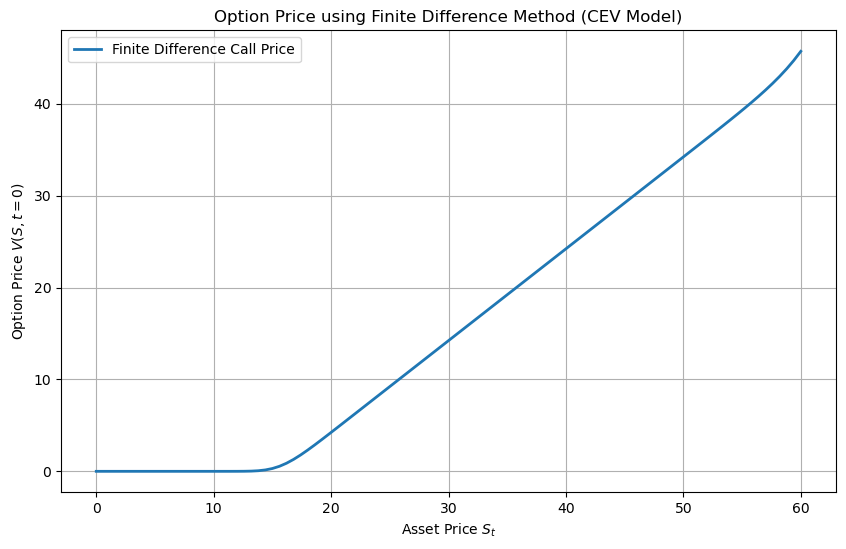

In [8]:
### FD Explicit Method ###

# Finite difference parameters
K = 15          # Strike price
S_max = 4 * K    # Maximum asset price
S_min = 0       # Minimum asset price
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter (CEV model)
T = 0.5         # Time to maturity
t_0 = 0         # Initial time
N_s = 100       # Number of asset price grid points
N_t = 500       # Number of time steps

# Discretization of asset price and time
dS = (S_max - S_min) / N_s
dt = T / N_t

# Asset price grid
S = np.linspace(S_min, S_max, N_s+1)

# Time grid
t = np.linspace(t_0, T, N_t+1)

# Initialize the option price matrix
V = np.zeros((N_s+1, N_t+1))

# Payoff at maturity (t = T) for a European call option
V[:, -1] = np.maximum(S - K, 0)

# Boundary conditions
V[0, :] = 0  # V(S=0, t) = 0 for a call option
V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

# Vectorized Finite difference loop (explicit method)
for j in reversed(range(N_t)):  # Loop over time from T to 0
    delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
    gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

    # CEV-based sigma term (S^gamma)
    diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
    drift_term = r * S[1:-1] * delta
    discount_term = r * V[1:-1, j+1]

    # Update option value using finite differences (vectorized)
    V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

# Extract the option prices at time t=0
option_price_finite_diff = V[:, 0]

# Plot the option price as a function of asset price
plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

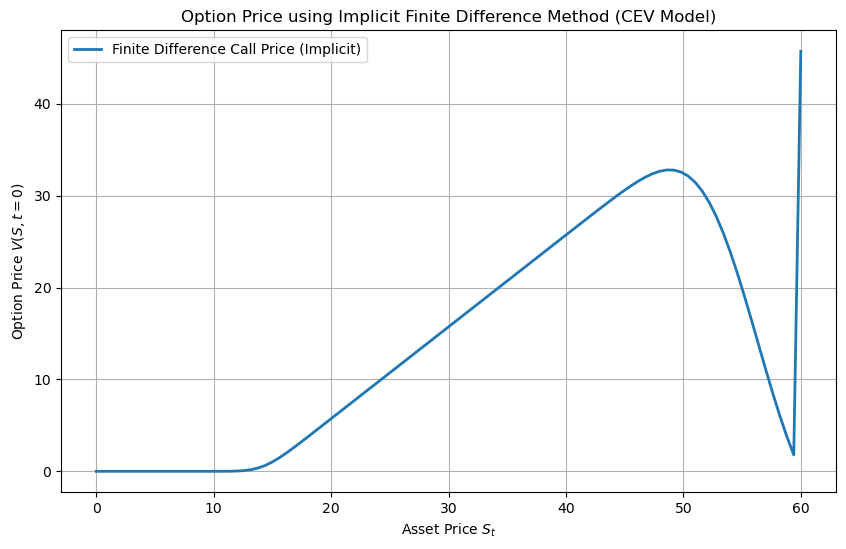

In [7]:
### FD Implicit Method ###

# Finite difference parameters
K = 15          # Strike price
S_max = 4 * K    # Maximum asset price
S_min = 0       # Minimum asset price
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter (CEV model)
T = 0.5         # Time to maturity
t_0 = 0         # Initial time
N_s = 100       # Number of asset price grid points
N_t = 500       # Number of time steps

# Discretization of asset price and time
dS = (S_max - S_min) / N_s
dt = T / N_t

# Asset price grid
S = np.linspace(S_min, S_max, N_s+1)

# Time grid
t = np.linspace(t_0, T, N_t+1)

# Initialize the option price matrix
V = np.zeros((N_s+1, N_t+1))

# Payoff at maturity (t = T) for a European call option
V[:, -1] = np.maximum(S - K, 0)

# Boundary conditions
V[0, :] = 0  # V(S=0, t) = 0 for a call option
V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

# Construct the tridiagonal matrix coefficients
alpha = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 - r * S[1:-1] / dS)
beta = -dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r)
gamma_term = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r * S[1:-1] / dS)

# Prepare the diagonals for the banded solver (for tridiagonal matrix)
lower_diag = -alpha[1:]  # lower diagonal (sub-diagonal)
main_diag = 1 - beta     # main diagonal
upper_diag = -gamma_term[:-1]  # upper diagonal (super-diagonal)

# Implicit method: solve the system at each time step
for j in reversed(range(N_t)):  # Loop over time from T to 0
    # Construct the RHS (right-hand side) as the current values of V[:, j+1]
    rhs = V[1:-1, j+1]

    # Solve the linear system: A * V[:, j] = V[:, j+1]
    ab = np.zeros((3, len(main_diag)))
    ab[0, 1:] = upper_diag  # upper diagonal
    ab[1, :] = main_diag    # main diagonal
    ab[2, :-1] = lower_diag  # lower diagonal

    V[1:-1, j] = solve_banded((1, 1), ab, rhs)

# Extract the option prices at time t=0
option_price_finite_diff = V[:, 0]

# Plot the option price as a function of asset price
plt.figure(figsize=(10, 6))
plt.plot(S, option_price_finite_diff, label="Finite Difference Call Price (Implicit)", lw=2)
plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Implicit Finite Difference Method (CEV Model)')
plt.legend()
plt.grid(True)
plt.show()

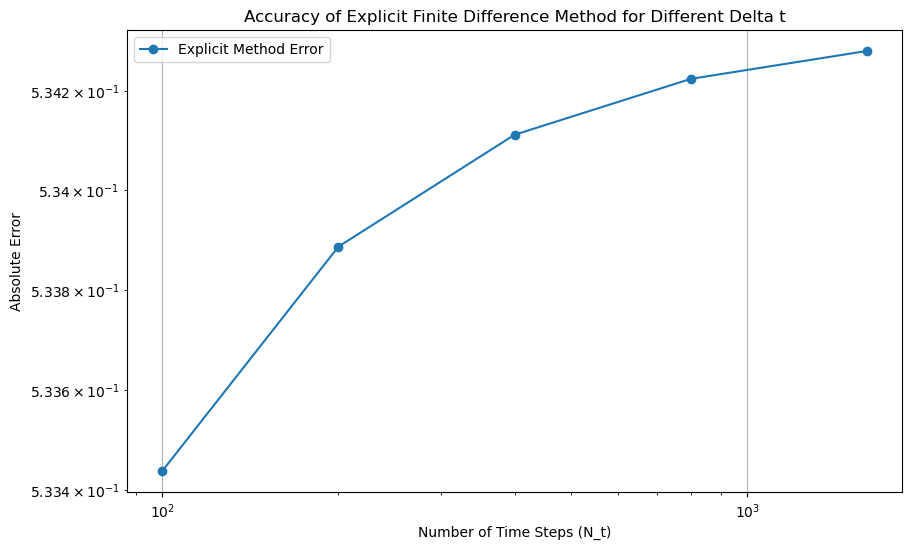

In [16]:
### Accuracy FD Explicit dt ###

# Function to compute option price using explicit finite difference method (for gamma = 1)
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Finite difference loop (explicit method)
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

        # CEV-based sigma term (S^gamma)
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        # Update option value using finite differences (vectorized)
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta t values (different time steps)
Nt_values = [100, 200, 400, 800, 1600]  # Different grid sizes for time steps
N_s = 100  # Fixed number of asset price grid points

# Store the errors for each delta t
errors = []

# Loop over different values of N_t
for N_t in Nt_values:
    # Compute the finite difference option price
    fd_price, S_grid = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((N_t, error))

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.loglog(errors[:, 0], errors[:, 1], 'o-', label="Explicit Method Error")
plt.xlabel('Number of Time Steps (N_t)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Explicit Finite Difference Method for Different Delta t')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:31: RuntimeWarning: overflow encountered in multiply
  diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:27: RuntimeWarning: invalid value encountered in subtract
  delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:36: RuntimeWarning: invalid value encountered in subtract
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\2492170682.py:36: RuntimeWarning: invalid value encountered in add
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)


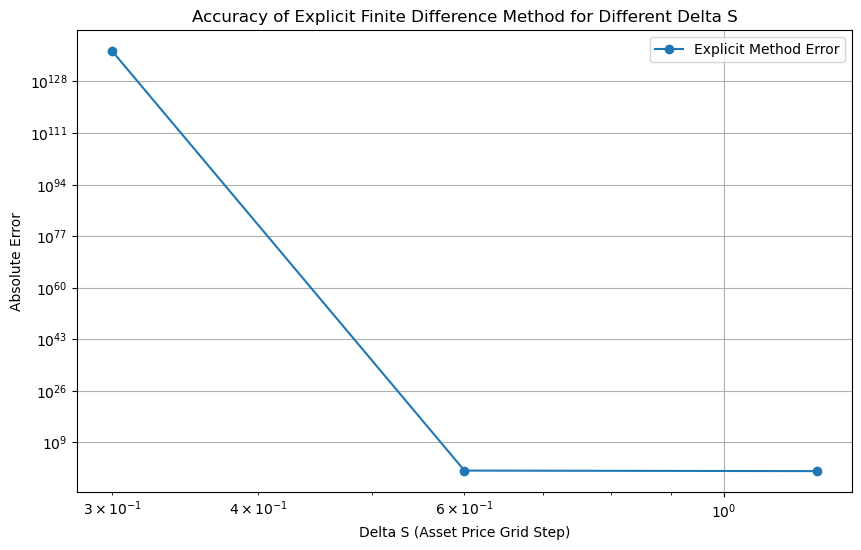

In [15]:
### Accuracy FD Explicit ds ###

# Function to compute option price using explicit finite difference method (for gamma = 1)
def finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Finite difference loop (explicit method)
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)  # First derivative (vectorized)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS ** 2)  # Second derivative (vectorized)

        # CEV-based sigma term (S^gamma)
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]

        # Update option value using finite differences (vectorized)
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14
N_t = 500  # Fixed number of time steps

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta S values (different asset price grids)
Ns_values = [50, 100, 200, 400]  # Different grid sizes for asset price

# Store the errors for each delta S
errors = []

# Loop over different values of N_s
for N_s in Ns_values:
    # Compute the finite difference option price
    fd_price, S_grid = finite_difference_explicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((S_max / N_s, error))  # Store delta S and the corresponding error

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors
plt.figure(figsize=(10, 6))
plt.loglog(errors[:, 0], errors[:, 1], 'o-', label="Explicit Method Error")
plt.xlabel('Delta S (Asset Price Grid Step)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Explicit Finite Difference Method for Different Delta S')
plt.grid(True)
plt.legend()
plt.show()

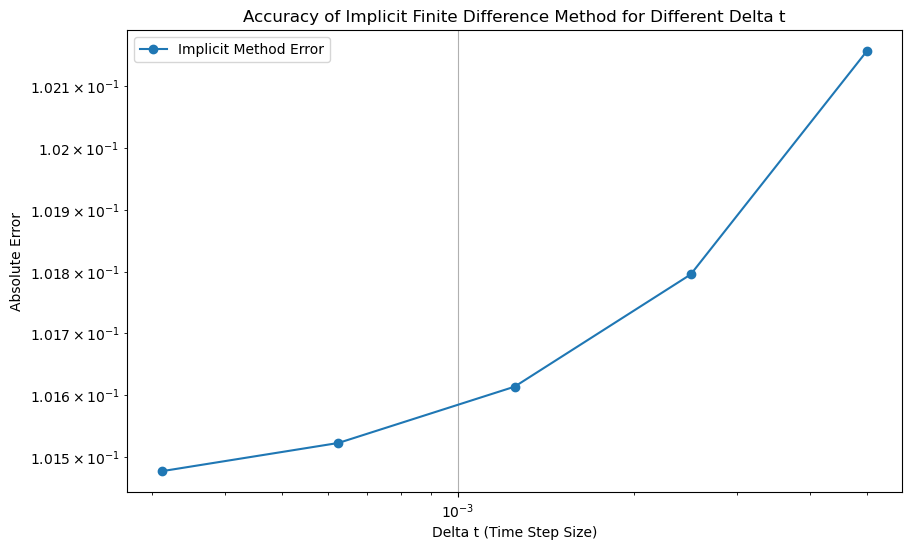

In [14]:
### Accuracy FD Implicit dt ###

# Function to compute option price using implicit finite difference method (for gamma = 1)
def finite_difference_implicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Construct the tridiagonal matrix coefficients
    alpha = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 - r * S[1:-1] / dS)
    beta = -dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r)
    gamma_term = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r * S[1:-1] / dS)

    # Prepare the diagonals for the banded solver (for tridiagonal matrix)
    lower_diag = -alpha[1:]  # lower diagonal (sub-diagonal)
    main_diag = 1 - beta     # main diagonal
    upper_diag = -gamma_term[:-1]  # upper diagonal (super-diagonal)

    # Implicit method: solve the system at each time step
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        rhs = V[1:-1, j+1]
        ab = np.zeros((3, len(main_diag)))
        ab[0, 1:] = upper_diag  # upper diagonal
        ab[1, :] = main_diag    # main diagonal
        ab[2, :-1] = lower_diag  # lower diagonal
        V[1:-1, j] = solve_banded((1, 1), ab, rhs)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14
N_s = 100  # Fixed number of asset price grid points

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta t values (different time grids)
Nt_values = [100, 200, 400, 800, 1600]  # Different grid sizes for time steps

# Store the errors for each delta t
errors = []

# Loop over different values of N_t
for N_t in Nt_values:
    # Compute the finite difference option price using the implicit method
    fd_price, S_grid = finite_difference_implicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((T / N_t, error))  # Store delta t and the corresponding error

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors for implicit method
plt.figure(figsize=(10, 6))
plt.loglog(errors[:, 0], errors[:, 1], 'o-', label="Implicit Method Error")
plt.xlabel('Delta t (Time Step Size)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Implicit Finite Difference Method for Different Delta t')
plt.grid(True)
plt.legend()
plt.show()

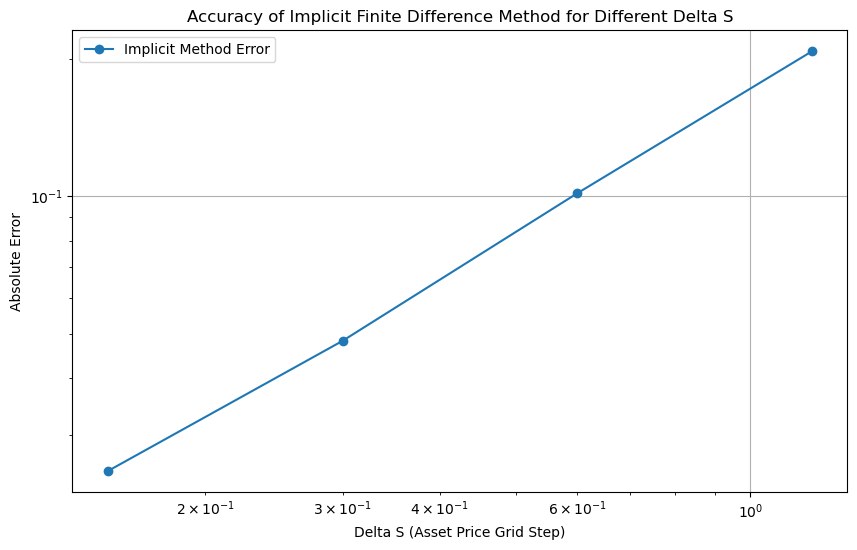

In [13]:
### Accuracy FD Implicit ds ###

# Function to compute option price using implicit finite difference method (for gamma = 1)
def finite_difference_implicit(K, S_max, r, sigma, gamma, T, N_s, N_t):
    # Discretization of asset price and time
    dS = S_max / N_s
    dt = T / N_t

    # Asset price grid
    S = np.linspace(0, S_max, N_s+1)

    # Time grid
    t = np.linspace(0, T, N_t+1)

    # Initialize the option price matrix
    V = np.zeros((N_s+1, N_t+1))

    # Payoff at maturity (t = T) for a European call option
    V[:, -1] = np.maximum(S - K, 0)

    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - t))  # V(S_max, t) behaves like S - K at large S

    # Construct the tridiagonal matrix coefficients
    alpha = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 - r * S[1:-1] / dS)
    beta = -dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r)
    gamma_term = 0.5 * dt * (sigma**2 * S[1:-1]**(2 * gamma) / dS**2 + r * S[1:-1] / dS)

    # Prepare the diagonals for the banded solver (for tridiagonal matrix)
    lower_diag = -alpha[1:]  # lower diagonal (sub-diagonal)
    main_diag = 1 - beta     # main diagonal
    upper_diag = -gamma_term[:-1]  # upper diagonal (super-diagonal)

    # Implicit method: solve the system at each time step
    for j in reversed(range(N_t)):  # Loop over time from T to 0
        rhs = V[1:-1, j+1]
        ab = np.zeros((3, len(main_diag)))
        ab[0, 1:] = upper_diag  # upper diagonal
        ab[1, :] = main_diag    # main diagonal
        ab[2, :-1] = lower_diag  # lower diagonal
        V[1:-1, j] = solve_banded((1, 1), ab, rhs)

    return V[:, 0], S  # Return option prices at t=0 and asset prices

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
gamma = 1  # Gamma = 1 for Black-Scholes
T = 0.5
S0 = 14
N_t = 500  # Fixed number of time steps

# Exact Black-Scholes price for gamma = 1
exact_price = bsexact(sigma, r, K, T, S0)

# Range of delta S values (different asset price grids)
Ns_values = [50, 100, 200, 400]  # Different grid sizes for asset price

# Store the errors for each delta S
errors = []

# Loop over different values of N_s
for N_s in Ns_values:
    # Compute the finite difference option price using the implicit method
    fd_price, S_grid = finite_difference_implicit(K, S_max, r, sigma, gamma, T, N_s, N_t)
    
    # Find the option price closest to S0 in the finite difference grid
    idx = (np.abs(S_grid - S0)).argmin()  # Find index where S is closest to S0
    fd_price_at_S0 = fd_price[idx]
    
    # Compute the absolute error
    error = np.abs(fd_price_at_S0 - exact_price)
    errors.append((S_max / N_s, error))  # Store delta S and the corresponding error

# Convert errors to a NumPy array for easier manipulation
errors = np.array(errors)

# Plotting the errors for implicit method
plt.figure(figsize=(10, 6))
plt.loglog(errors[:, 0], errors[:, 1], 'o-', label="Implicit Method Error")
plt.xlabel('Delta S (Asset Price Grid Step)')
plt.ylabel('Absolute Error')
plt.title('Accuracy of Implicit Finite Difference Method for Different Delta S')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
### Stability FD Explicit ###

# Parameters
K = 15          # Strike price
S_max = 4 * K   # Maximum asset price
S_min = 1e-5    # Minimum asset price (small positive to avoid div by zero)
r = 0.1         # Risk-free rate
sigma = 0.25    # Volatility
gamma = 0.8     # Elasticity parameter (CEV model)
T = 0.5         # Time to maturity
t_0 = 0         # Initial time
N_s = 100       # Number of asset price grid points

# Discretization
dS = (S_max - S_min) / N_s
stable_limit = 2 * (dS**2) / (sigma**2 * S_max**2)

# Function to check for instability by varying N_t
def check_stability(start_N_t, max_N_t, step_N_t):
    for N_t in range(start_N_t, max_N_t + 1, step_N_t):
        dt = T / N_t
        CFL = sigma**2 * S_max**2 * dt / dS**2
        
        # Check CFL condition
        if CFL >= 1:
            print(f"CFL condition violated: N_t = {N_t}, CFL = {CFL:.4f} (dt = {dt:.6f})")
            print(f"Instability likely at N_t = {N_t}")
            return N_t  # Return the time step number where instability occurs
        else:
            print(f"CFL condition satisfied: N_t = {N_t}, CFL = {CFL:.4f} (dt = {dt:.6f})")
    
    return None  # If no instability found in the range

# Call the function with a range of time steps
start_N_t = 100     # Starting number of time steps
max_N_t = 2000      # Maximum number of time steps to test
step_N_t = 100      # Increment of N_t

unstable_N_t = check_stability(start_N_t, max_N_t, step_N_t)

if unstable_N_t:
    print(f"Solver becomes unstable at N_t = {unstable_N_t}")
else:
    print("Solver remained stable in the tested range.")


CFL condition violated: N_t = 100, CFL = 3.1250 (dt = 0.005000)
Instability likely at N_t = 100
Solver becomes unstable at N_t = 100


C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\625845872.py:24: RuntimeWarning: overflow encountered in multiply
  diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\625845872.py:21: RuntimeWarning: invalid value encountered in subtract
  delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\625845872.py:29: RuntimeWarning: invalid value encountered in subtract
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)
C:\Users\pontu\AppData\Local\Temp\ipykernel_11100\625845872.py:29: RuntimeWarning: invalid value encountered in add
  V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)


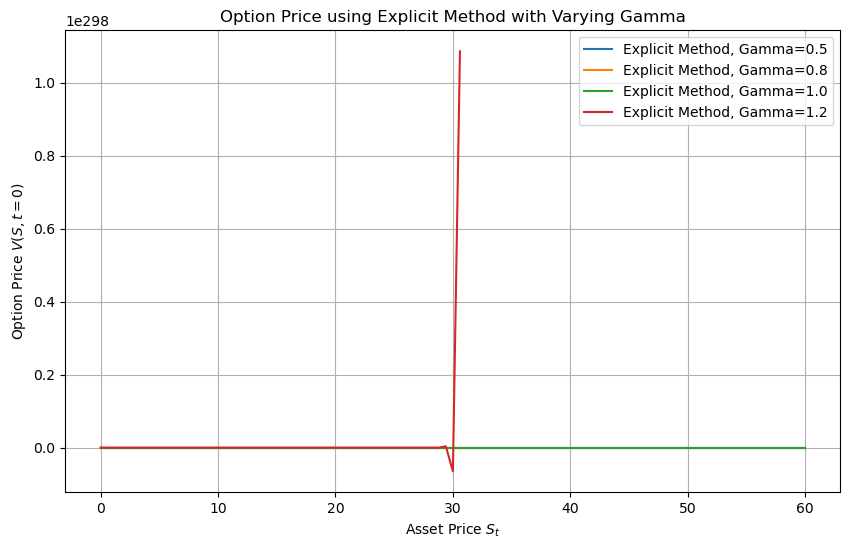

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate option price using the explicit method
def explicit_method_cev(K, S_max, r, sigma, gamma, T, N_s, N_t):
    dS = S_max / N_s
    dt = T / N_t
    
    S = np.linspace(0, S_max, N_s+1)
    V = np.zeros((N_s+1, N_t+1))
    
    # Payoff at maturity
    V[:, -1] = np.maximum(S - K, 0)
    
    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - np.linspace(0, T, N_t+1)))
    
    # Time-stepping for explicit method
    for j in reversed(range(N_t)):
        delta = (V[2:, j+1] - V[:-2, j+1]) / (2 * dS)
        gamma_term = (V[2:, j+1] - 2 * V[1:-1, j+1] + V[:-2, j+1]) / (dS**2)
        
        diffusion_term = 0.5 * sigma**2 * S[1:-1]**(2 * gamma) * gamma_term
        drift_term = r * S[1:-1] * delta
        discount_term = r * V[1:-1, j+1]
        
        # Update option price
        V[1:-1, j] = V[1:-1, j+1] + dt * (diffusion_term - drift_term + discount_term)
    
    return S, V[:, 0]

# Parameters
K = 15
S_max = 4 * K
r = 0.1
sigma = 0.25
T = 0.5
N_s = 100
N_t = 500

# Varying gamma
gamma_values = [0.5, 0.8, 1.0, 1.2]

# Plot results for explicit method
plt.figure(figsize=(10, 6))
for gamma in gamma_values:
    S, option_price = explicit_method_cev(K, S_max, r, sigma, gamma, T, N_s, N_t)
    plt.plot(S, option_price, label=f'Explicit Method, Gamma={gamma}')

plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Explicit Method with Varying Gamma')
plt.legend()
plt.grid(True)
plt.show()


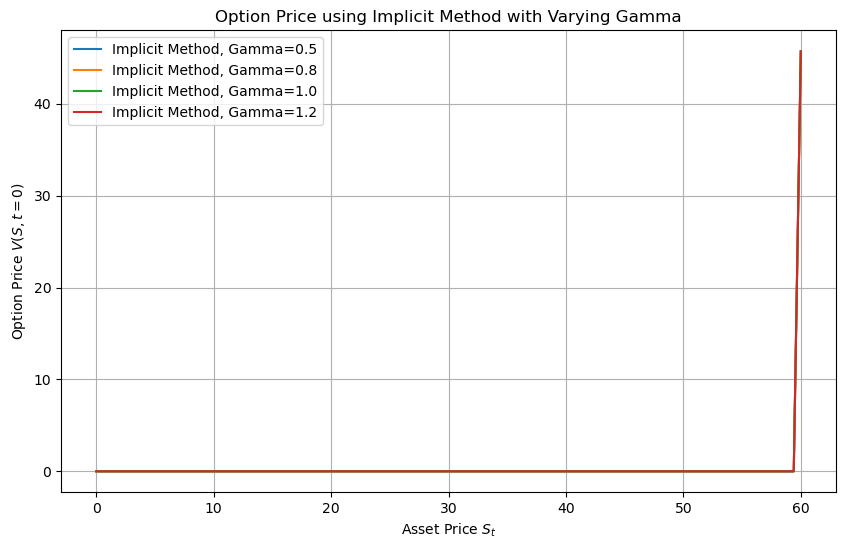

In [19]:
# Function to calculate option price using the implicit method
def implicit_method_cev(K, S_max, r, sigma, gamma, T, N_s, N_t):
    dS = S_max / N_s
    dt = T / N_t
    
    S = np.linspace(0, S_max, N_s+1)
    V = np.zeros((N_s+1, N_t+1))
    
    # Payoff at maturity
    V[:, -1] = np.maximum(S - K, 0)
    
    # Boundary conditions
    V[0, :] = 0  # V(S=0, t) = 0 for a call option
    V[-1, :] = S_max - K * np.exp(-r * (T - np.linspace(0, T, N_t+1)))
    
    # Coefficient matrix for implicit method
    A = np.zeros((N_s-1, N_s-1))
    
    for i in range(1, N_s):
        alpha = 0.5 * sigma**2 * S[i]**(2 * gamma) / dS**2
        beta = r * S[i] / (2 * dS)
        
        # Fill matrix A (tridiagonal)
        if i > 1:
            A[i-1, i-2] = alpha - beta
        A[i-1, i-1] = 1/dt + 2 * alpha + r
        if i < N_s-1:
            A[i-1, i] = alpha + beta
    
    # Time-stepping for implicit method
    for j in reversed(range(N_t)):
        V[1:-1, j] = np.linalg.solve(A, V[1:-1, j+1])
    
    return S, V[:, 0]

# Plot results for implicit method
plt.figure(figsize=(10, 6))
for gamma in gamma_values:
    S, option_price = implicit_method_cev(K, S_max, r, sigma, gamma, T, N_s, N_t)
    plt.plot(S, option_price, label=f'Implicit Method, Gamma={gamma}')

plt.xlabel('Asset Price $S_t$')
plt.ylabel('Option Price $V(S, t=0)$')
plt.title('Option Price using Implicit Method with Varying Gamma')
plt.legend()
plt.grid(True)
plt.show()
